in this part, first models will be built and compared on the the z_scaled dataset, which has been cleaned, applied feature selection, and standardized, containing 32 features (excluding fraud label).

then, the best model will be built on the dataset that has been reduced to 5  component (the best and least to explain 95% variance) by pca. The results on two dataset will be compared.

at last, the best model will be applied on the best dataset's out of time (oot) set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import pickle
import warnings
warnings.filterwarnings('ignore')

# Model imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model selection and evaluation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, roc_curve, precision_recall_curve, 
                           confusion_matrix, classification_report, average_precision_score)
# self-definced functions
from func import optimize_dtypes

# Load dataset

In [2]:
z_scaled = pd.read_csv('./data/z_scaled.csv', index_col=0)
print('dataset shape: ', z_scaled.shape)
print('5 sample:')
display(z_scaled.sample(5))
z_scaled = optimize_dtypes(z_scaled)

dataset shape:  (981694, 39)
5 sample:


,fulladdress_count_30,address_count_14,fulladdress_count_14,address_count_7,fulladdress_count_7,fulladdress_count_0_by_7,address_count_1,fulladdress_count_1,ssn_dob_count_30,ssn_count_30,...,fulladdress_homephone_count_7,fulladdress_homephone_count_0_by_30,ssn_dob_count_0_by_14,ssn_ssn_count_0_by_30,ssn_firstname_count_0_by_14,ssn_ssn_count_7,ssn_lastname_count_0_by_30,ssn_name_count_0_by_30,name_dob_count_0_by_30,fraud_label
780252,-0.10148,-0.088118,-0.078613,-0.072244,-0.066696,0.102735,-0.050525,-0.049118,-0.09749,-0.098988,...,-0.057383,0.171797,0.124092,0.174492,0.124638,-0.057567,0.173035,0.1727,0.177126,0
851120,-0.10148,-0.088118,-0.078613,-0.072244,-0.066696,0.102735,-0.050525,-0.049118,-0.09749,-0.098988,...,-0.057383,0.171797,0.124092,0.174492,0.124638,-0.057567,0.173035,0.1727,0.177126,0
718734,-0.10148,-0.088118,-0.078613,-0.072244,-0.066696,0.102735,-0.050525,-0.049118,-0.09749,-0.098988,...,-0.057383,0.171797,0.124092,0.174492,0.124638,-0.057567,0.173035,0.1727,0.177126,0
500892,-0.10148,-0.088118,-0.078613,-0.072244,-0.066696,0.102735,-0.050525,-0.049118,-0.09749,-0.098988,...,-0.057383,0.171797,0.124092,0.174492,0.124638,-0.057567,0.173035,0.1727,0.177126,0
931994,-0.10148,-0.088118,-0.078613,-0.072244,-0.066696,0.102735,-0.050525,-0.049118,-0.09749,-0.098988,...,-0.057383,0.171797,0.124092,0.174492,0.124638,-0.057567,0.173035,0.1727,0.177126,0



OPTIMIZING DATA TYPES
----------------------------------------
Starting memory usage: 299.59 MB
Ending memory usage: 150.73 MB
Memory reduction: 49.7%


## split statistics
- 80% train, test set (X, y will be divided by train_test_split function) and
- 20% Out Of Time (OOT) set for validation of the best model

In [3]:
total = z_scaled.shape[0]
X = z_scaled.drop(['fraud_label'], axis=1)
y = z_scaled.fraud_label
X_oot = X[round(total*0.8):]
y_oot = y[round(total*0.8):]
X = X[0:round(total*0.8)]
y = y[0:round(total*0.8)]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(f"Train set loaded: {X_train.shape}")
print(f"Test set loaded: {X_test.shape}")
print(f"OOT set loaded: {X_oot.shape}")
print("check length sum euqals to original length: ",len(y_train)+len(y_test)+len(y_oot)==len(z_scaled.fraud_label))
print(f"Fraud rate in train: {y_train.mean()*100:.2f}%")

Train set loaded: (549748, 38)
Test set loaded: (235607, 38)
OOT set loaded: (196339, 38)
check length sum euqals to original length:  True
Fraud rate in train: 1.45%


# Build and Compare Baseline Models

traditional svm works really slow for this huge dataset, and from the previous research, it didn't show any better than GBDT, so just skip it here. 
- have not tried replacing it with its approximations, such as LinearSVC and SGDClassifier

In [4]:
baseline_models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    #'SVM': SVC(probability=True, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbosity=-1)
}


baseline_results = {}

for name, model in baseline_models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    baseline_results[name] = {
        'model': model,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'avg_precision': average_precision_score(y_test, y_pred_proba),
        'train_time': time.time() - start_time
    }
    
    print(f"ROC-AUC: {baseline_results[name]['roc_auc']:.4f}")
    print(f"F1 Score: {baseline_results[name]['f1']:.4f}")
    print(f"Training time: {baseline_results[name]['train_time']:.2f} seconds")

# Display baseline results
baseline_df = pd.DataFrame(baseline_results).T
print("\nBaseline Model Comparison:")
print(baseline_df.round(4))


Training Logistic Regression...
ROC-AUC: 0.7696
F1 Score: 0.5582
Training time: 1.42 seconds

Training Decision Tree...
ROC-AUC: 0.7250
F1 Score: 0.5852
Training time: 1.09 seconds

Training Random Forest...
ROC-AUC: 0.7643
F1 Score: 0.5937
Training time: 4.76 seconds

Training Gradient Boosting...
ROC-AUC: 0.7647
F1 Score: 0.6145
Training time: 17.59 seconds

Training Neural Network...
ROC-AUC: 0.7686
F1 Score: 0.6159
Training time: 32.89 seconds

Training XGBoost...
ROC-AUC: 0.7673
F1 Score: 0.6051
Training time: 1.26 seconds

Training LightGBM...
ROC-AUC: 0.7667
F1 Score: 0.6119
Training time: 1.95 seconds

Baseline Model Comparison:
                                                                 model  \
Logistic Regression  LogisticRegression(max_iter=1000, random_state...   
Decision Tree                  DecisionTreeClassifier(random_state=42)   
Random Forest        (DecisionTreeClassifier(max_features='sqrt', r...   
Gradient Boosting    ([DecisionTreeRegressor(criterion='fr

In [29]:
baseline_df.to_csv('Baseline Model Performance.csv')

For Fraud Detection, Recall (aka True Positive Rate or Sensitivity) is crucial that we want to catch as many fraud cases as possible, i.e.the cost of missing a true positive is high. However, it can also increase the risk of false alarms. Thus, to choose the proper models for further training, we have to consider all metrics and prioritize certain metrics over others. After a glance of the above results, GBDT and NN are the two choices for me, just like what we have done in the paper years ago. For future efficiency, let's utilize self-defined function combining multiple metrics with customizable weights.
* and training time may need to be taken into consideration in real situation
$$Recall = \frac{TP}{TP + FN}$$

In [3]:
#baseline_df = pd.read_csv('Baseline Model Performance.csv', index_col=0)
#baseline_df

In [4]:
from func import select_best_fraud_models
fraud_weights = {
        'recall': 0.35,       # Most important - catch fraud cases
        'f1': 0.25,           # Balance of precision and recall
        'precision': 0.15,    # Avoid too many false alarms
        'roc_auc': 0.15,      # Overall discrimination ability
        'avg_precision': 0.10 # Performance across thresholds
    }
top_models, weighted_score = select_best_fraud_models(baseline_df, top_n=3, weights=fraud_weights)

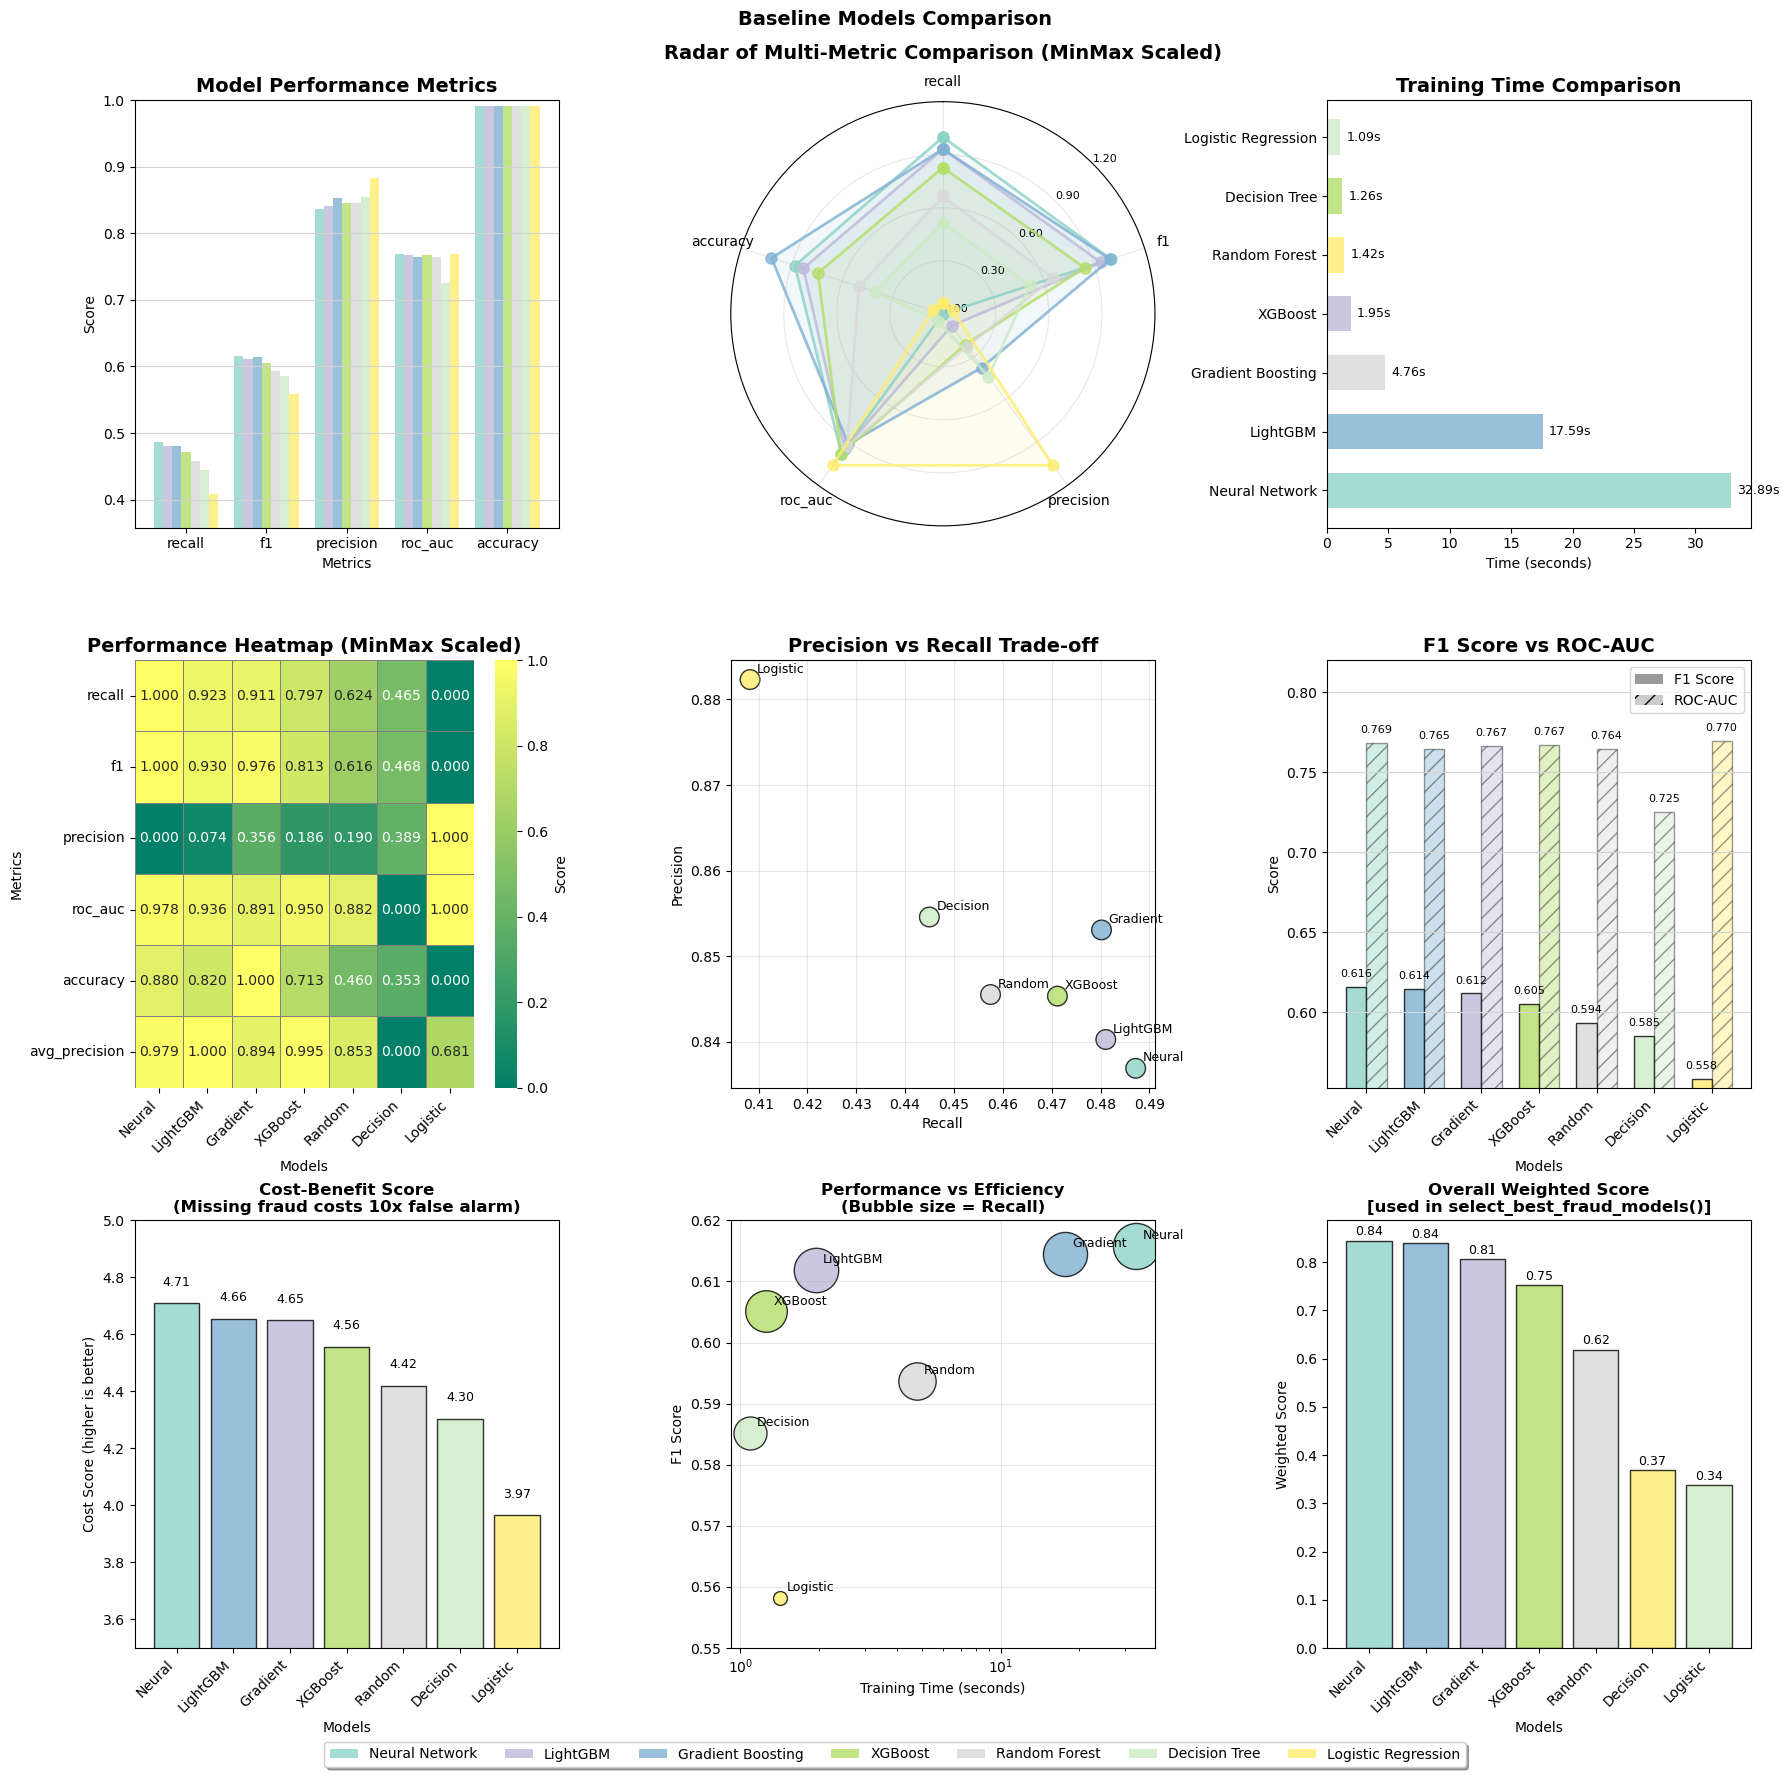

In [5]:
from func import plot_model_comparison
plot_model_comparison(baseline_df, weights = fraud_weights, top_n=3, 
                      figsize=(18, 18), figsave=True, figtitle = 'Baseline Models Comparison')

# Hyperparameter Optimization
Select top 3 models for optimization based on baseline performance

In [7]:
top_models

['Neural Network', 'Gradient Boosting', 'LightGBM']

In [7]:
# Define parameter grids based on the previous results shown in the paper
param_grids = {
    'Random Forest': {
        'n_estimators': [120, 500, 800],
        'max_depth': [5, 10, 15],
        'min_samples_split': [5, 10, 20],
        'min_samples_leaf': [5, 10, 15],
        'class_weight': ['balanced', {0: 1, 1: 100}]
    },
    'Gradient Boosting': {
        'n_estimators': [500, 800, 1000],
        'max_depth': [5, 6, 10],         
        'learning_rate': [0.01, 0.02, 0.05],
        'subsample': [0.2, 0.5, 0.8],
        'min_samples_split': [10, 20]
    },
    'XGBoost': {
        'n_estimators': [100, 500, 800],
        'max_depth': [5, 6, 10],
        'learning_rate': [0.01, 0.02, 0.05],
        'subsample': [0.2, 0.5, 0.8],
        'colsample_bytree': [0.8, 1.0],
        'scale_pos_weight': [50, 100, 200]
    },
    'LightGBM': {
        'n_estimators': [100, 500, 800],
        'max_depth': [4, 6, 8],
        'learning_rate': [0.01, 0.02, 0.05, 0.1],
        'num_leaves': [31, 50, 100],
        'feature_fraction': [0.8, 1.0],
        'bagging_fraction': [0.8, 1.0],
        'bagging_freq': [5, 10]
    },
    'Neural Network': {
        'hidden_layer_sizes': [(10,), (100,), (100, 50), (100, 50, 25)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
}

optimized_models = {}

**a little plug here**, to train faster, if there is cuda GPUS (usually windows OS), can use:
- XGBClassifier(tree_method='gpu_hist', ...)
- LGBMClassifier(device='gpu', ...)
- NN: switch to PyTorch or TensorFlow (for mac silicon, tf is recommended)
- SVM: RAPIDS cuML or ThunderSVM

In [8]:
# Parallel Processing Multiple Models
from joblib import Parallel, delayed

# Define the optimization function that will run in parallel
def optimize_model(model_name, X_train, y_train, param_grid):
    print(f"\nStarting optimization for {model_name}...")
    start_time = time.time()
    
    # Get base model
    if model_name == 'Random Forest':
        base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    elif model_name == 'Gradient Boosting':
        base_model = GradientBoostingClassifier(random_state=42)
    elif model_name == 'XGBoost':
        base_model = XGBClassifier(random_state=42, eval_metric='logloss')
    elif model_name == 'LightGBM':
        base_model = LGBMClassifier(random_state=42, verbosity=-1, is_unbalance=True)
    elif model_name == 'Neural Network':
        base_model = MLPClassifier(max_iter=1000, random_state=42)
    
    # Grid search with cross-validation
    grid_search = GridSearchCV(
        base_model,
        param_grid,
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        scoring='roc_auc',
        n_jobs=-1,
        verbose=0  # Set to 0 for cleaner parallel output
    )
    
    # Fit grid search
    grid_search.fit(X_train, y_train)
    
    # Calculate time taken
    time_taken = time.time() - start_time
    
    print(f"\nCompleted {model_name} in {time_taken:.2f} seconds")
    print(f"- Best parameters: {grid_search.best_params_}")
    print(f"- Best CV ROC-AUC: {grid_search.best_score_:.4f}")
    
    return model_name, {
        'model': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'cv_score': grid_search.best_score_,
        'time_taken': time_taken
    }

In [9]:
print("Starting parallel optimization...")
overall_start = time.time()

results = Parallel(n_jobs=-1)(
    delayed(optimize_model)(model_name, X_train, y_train, param_grids[model_name])
    for model_name in top_models
    if model_name in param_grids
)

# Convert results to dictionary
optimized_models = dict(results)

overall_time = time.time() - overall_start
print(f"\nTotal optimization time: {overall_time:.2f} seconds")
print(f"Successfully optimized {len(optimized_models)} models")

# Print summary
print("\nOptimization Summary:")
print("-" * 60)
for model_name, result in optimized_models.items():
    print(f"{model_name}: CV Score = {result['cv_score']:.4f}, Time = {result['time_taken']:.2f}s")

Starting parallel optimization...

Starting optimization for Gradient Boosting...

Starting optimization for Neural Network...

Starting optimization for LightGBM...

Completed Gradient Boosting in 12335.17 seconds
- Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 20, 'n_estimators': 500, 'subsample': 0.8}
- Best CV ROC-AUC: 0.7721

Completed Neural Network in 12452.43 seconds
- Best parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
- Best CV ROC-AUC: 0.7716

Completed LightGBM in 35391.88 seconds
- Best parameters: {'bagging_fraction': 0.8, 'bagging_freq': 10, 'feature_fraction': 1.0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500, 'num_leaves': 31}
- Best CV ROC-AUC: 0.7723

Total optimization time: 35393.90 seconds
Successfully optimized 3 models

Optimization Summary:
------------------------------------------------------------
Neural Network: CV Score = 0.7716, Ti

In [15]:
# optimize each model one by one
# for model_name in top_models:
#     if model_name in param_grids:
#         print(f"\nOptimizing {model_name}...")
        
#         # Get base model
#         if model_name == 'Random Forest':
#             base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
#         elif model_name == 'Gradient Boosting':
#             base_model = GradientBoostingClassifier(random_state=42)
#         elif model_name == 'XGBoost':
#             base_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
#         elif model_name == 'LightGBM':
#             base_model = LGBMClassifier(random_state=42, verbosity=-1, is_unbalance=True)
#         elif model_name == 'Neural Network':
#             base_model = MLPClassifier(max_iter=1000, random_state=42)
        
#         # Grid search with cross-validation
#         grid_search = GridSearchCV(
#             base_model,
#             param_grids[model_name],
#             cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
#             scoring='roc_auc',
#             n_jobs=-1,
#             verbose=1
#         )
        
#         # Fit grid search
#         grid_search.fit(X_train, y_train)
        
#         # Store best model
#         optimized_models[model_name] = {
#             'model': grid_search.best_estimator_,
#             'best_params': grid_search.best_params_,
#             'cv_score': grid_search.best_score_
#         }
        
#         print(f"Best parameters: {grid_search.best_params_}")
#         print(f"Best CV ROC-AUC: {grid_search.best_score_:.4f}")

In [33]:
pd.DataFrame(optimized_models).to_csv('Top3 Optimized Results.csv')

## Calculate the Optimized Models' Performance with the best parameters

In [6]:
# 80% train, test set (X, y will be divided by train_test_split function) and
# 20% Out Of Time (OOT) set for validation of the best model
z_scaled = pd.read_csv('./data/z_scaled.csv', index_col=0)
z_scaled = optimize_dtypes(z_scaled)
total = z_scaled.shape[0]
X = z_scaled.drop(['fraud_label'], axis=1)
y = z_scaled.fraud_label
X_oot = X[round(total*0.8):]
y_oot = y[round(total*0.8):]
X = X[0:round(total*0.8)]
y = y[0:round(total*0.8)]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
del z_scaled


OPTIMIZING DATA TYPES
----------------------------------------
Starting memory usage: 299.59 MB
Ending memory usage: 150.73 MB
Memory reduction: 49.7%


In [7]:
result = pd.read_csv('Top3 Optimized Results.csv', index_col=0)
result

,Neural Network,Gradient Boosting,LightGBM
model,"MLPClassifier(alpha=0.01, max_iter=1000, rando...","GradientBoostingClassifier(learning_rate=0.05,...","LGBMClassifier(bagging_fraction=0.8, bagging_f..."
best_params,"{'activation': 'relu', 'alpha': 0.01, 'hidden_...","{'learning_rate': 0.05, 'max_depth': 5, 'min_s...","{'bagging_fraction': 0.8, 'bagging_freq': 10, ..."
cv_score,0.7716063949041617,0.7721070159820956,0.7723323075775402
time_taken,12452.43071269989,12335.17368721962,35391.87643098831


In [ ]:
# Convert string to actual model objects
optimized_models = {name: eval(model_str) for name, model_str in dict(result.loc['model',:]).items()}
optimized_results = {}

for name, model in optimized_models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    optimized_results[name] = {
        'model': model,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'avg_precision': average_precision_score(y_test, y_pred_proba),
        'train_time': time.time() - start_time
    }
    
    print(f"ROC-AUC: {optimized_results[name]['roc_auc']:.4f}")
    print(f"F1 Score: {optimized_results[name]['f1']:.4f}")
    print(f"Training time: {optimized_results[name]['train_time']:.2f} seconds")

# Display optimized models results
optimized_df = pd.DataFrame(optimized_results).T
print("\nOptimized Model Comparison:")
print(optimized_df.round(4))


Training Neural Network...


In [ ]:
optimized_df.to_csv('Optimized Model Performance.csv')

In [3]:
#optimized_df = pd.read_csv('Optimized Model Performance.csv', index_col=0)
#optimized_df

In [ ]:
from func import select_best_fraud_models
fraud_weights = {
        'recall': 0.35,       # Most important - catch fraud cases
        'f1': 0.25,           # Balance of precision and recall
        'precision': 0.15,    # Avoid too many false alarms
        'roc_auc': 0.15,      # Overall discrimination ability
        'avg_precision': 0.10 # Performance across thresholds
    }
top_models, weighted_score = select_best_fraud_models(optimized_df, top_n=1, weights=fraud_weights)

In [ ]:
from func import plot_model_comparison
plot_model_comparison(optimized_df, weights = fraud_weights, top_n=1, 
                      figsize=(18, 18), figsave=True, figtitle = 'Optimized Model Comparison')